In [3]:
import pandas as pd

file_path = 'prueba tolu.txt'

names = ['fecha',
         'RadAlb',
        'RadRef',
        'RadSolar1',
        'Temperature_HV',
        'RadSolar2',
        'Humidity_HV',
        'lluvia_total',
        'Direccion_Viento',
        'Albedo',
        'Pressure',
        'Velocidad_Viento']

# Leer el archivo saltando y tomando la segunda fila como nombres de columnas
df= pd.read_csv(file_path, delimiter='\t', skiprows=1, header=1, names=names)


In [4]:
#print(df.size)
df.head(3)
#print(f"Número de filas: {df.shape[0]}")
#print(f"Número de columnas: {df.shape[1]}")


,fecha,RadAlb,RadRef,RadSolar1,Temperature_HV,RadSolar2,Humidity_HV,lluvia_total,Direccion_Viento,Albedo,Pressure,Velocidad_Viento
0,2023-11-04 00:00:00,-0.254,-0.105,-0.102,25.692,0.034,91.594,324.9,66,-0.149,1001.268,1.0
1,2023-11-04 00:01:00,-0.214,-0.081,-0.045,25.688,0.181,91.707,324.9,61,-0.133,1001.274,1.0
2,2023-11-04 00:02:00,-0.239,-0.133,-0.118,25.675,0.139,91.596,324.9,63,-0.106,1001.267,1.0


In [5]:
# paso la hora a formato fecha
df['fecha'] = pd.to_datetime(df['fecha'])
#saco la media ypoingo encabezados
media_por_minuto = df.groupby([df['fecha'].dt.hour,df['fecha'].dt.minute])[['RadAlb',
                                                                          'RadRef',
                                                                        'RadSolar1',
                                                                        'Temperature_HV',
                                                                        'RadSolar2',
                                                                        'Humidity_HV',
                                                                        'lluvia_total',
                                                                        'Direccion_Viento',
                                                                        'Albedo',
                                                                        'Pressure',
                                                                        'Velocidad_Viento']].mean()
#calcula las medias para cada minuto en los tomando los datos de los dias
#print(f"Número de filas: {media_por_minuto.shape[0]}")
media_por_minuto.head(3)

RadAlb    RadRef  RadSolar1  Temperature_HV  RadSolar2  \
fecha fecha                                                             
0     0     -0.272737 -0.207895  -0.332526       25.701895  -0.319158   
      1     -0.264105 -0.217421  -0.340842       25.691684  -0.346263   
      2     -0.248368 -0.214105  -0.351316       25.690895  -0.356053   

             Humidity_HV  lluvia_total  Direccion_Viento    Albedo  \
fecha fecha                                                          
0     0        92.073105    347.724474        126.578947 -0.065000   
      1        92.070263    347.724474        112.315789 -0.046737   
      2        92.062684    347.726789        104.105263 -0.034316   

                Pressure  Velocidad_Viento  
fecha fecha                                 
0     0      1002.016053          0.684211  
      1      1002.003842          0.631579  
      2      1001.994895          0.473684

C:\Users\Arcano\AppData\Local\Temp\ipykernel_12064\1730148195.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  rango_fechas = pd.date_range(start=df['fecha'].min(), end=df['fecha'].max(), freq='T')


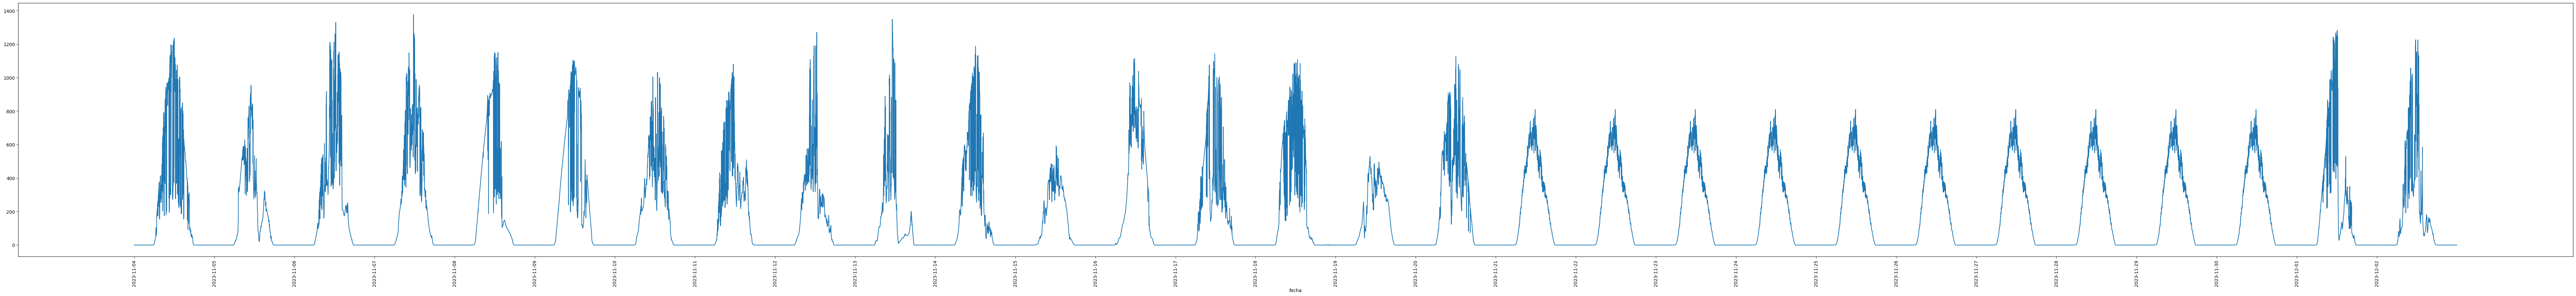

In [17]:
import matplotlib.pyplot as plt

# Crear un rango completo de fechas con frecuencia de un minuto
rango_fechas = pd.date_range(start=df['fecha'].min(), end=df['fecha'].max(), freq='T')

# Convertir el rango a un DataFrame
df_rango = pd.DataFrame(rango_fechas, columns=['fecha'])

# unimos df con df_rango para tener un listado completo
df_completo = pd.merge(df_rango, df, on='fecha', how='left')

#comvertimos hora y minutos en sus propias columnas
df_completo['Hora'] = df_completo['fecha'].dt.hour
df_completo['Minuto'] = df_completo['fecha'].dt.minute

# unimos df_completo y media_por_minuto
df_rel = pd.merge(df_completo, media_por_minuto, 
                     left_on=['Hora', 'Minuto'], 
                     right_index=True, 
                     how='left', 
                     suffixes=('', '_media'))

# Lista de columnas numéricas para las que se completarán los NaN
columnas = ['RadAlb', 'RadRef', 'RadSolar1', 'Temperature_HV', 
            'RadSolar2', 'Humidity_HV', 'Direccion_Viento', 
            'Albedo', 'Pressure', 'Velocidad_Viento']

# Rellenar los valores NaN en cada columna con la media correspondiente
for col in columnas:
    df_rel[col] = df_rel[col].fillna(df_rel[col + '_media'])


for i in range(1, len(df_rel)):
    #buscamos los valorees NaN en lluvia_total
    if pd.isna(df_rel.loc[i, 'lluvia_total']):
        #sacamos el valor superior de NaN encontrado
        valor_superior = df_rel.loc[i - 1, 'lluvia_total']
        # Si el valor superior no es NaN por seguridad
        if not pd.isna(valor_superior):
            # Verificar si el valor superior es menor
            if valor_superior < df_rel.loc[i - 1, 'lluvia_total']:
                # si el valor superor es menor rellenamos con la media
                hora = df_rel.loc[i, 'fecha'].hour
                minuto = df_rel.loc[i, 'fecha'].minute
                df_rel.loc[i, 'lluvia_total'] = media_por_minuto.loc[(hora, minuto), 'lluvia_total']
            else:
                # encaso contrario rellenamos con el valor superior
                df_rel.loc[i, 'lluvia_total'] = valor_superior

#df_rel.head(24483)

# tamaño del plot
Sfig = plt.figure(figsize=(100, 10))

# datos x & y que van en el plot
plt.plot(df_rel.iloc[:,0], df_rel.iloc[:,1])

# Crear un rango completo de fechas con frecuencia de un dias
rango_dias = pd.date_range(start=df_rel['fecha'].min(), end=df_rel['fecha'].max(), freq='D')

# escala en x del plot
plt.xticks(rango_dias, rotation=90) 
# etiquetas varias
plt.xlabel('fecha')
#plt.ylabel('RadAld') # deben ser cambiados a mano y tengo flojera
#plt.title('RadAld vs fechas')
plt.show()

